In [1]:
%%html
<style>
table {float:left}
</style>

# <font color="red">Session 4 Challenge:</font><br>Denoising Quantum Autoencoders

<table>
    <tr><td style="vertical-align: top;"><strong>Aim:</strong></td>
        <td>Create and test a quantum autoencoder (QAE) in PennyLane,<br>
            using time series data with the sliding window protocol.<br>
            Then understand the workings of pure quantum QAE.<br>
            Subsequently, implement a hybrid quantum-classical QAEs.<br>
            Finally, compare both models and their performance.<br>
            To facilitate manipulation of time series windows,<br>
            this notebook uses the provided "window.py" utility functions.
        </td></tr>
    <tr><td style="vertical-align: top;"><strong>Author:</strong></td>
        <td>Jacob L. Cybulski (<a href="https://jacobcybulski.com/" target="_blank">website</a>),
            <em>Enquanted</em></td></tr>
    <tr><td style="vertical-align: top;"><strong>Release:</strong></td>
        <td>September 2025</td></tr>
    <tr><td style="vertical-align: top;"><strong>Datasets</strong></td>
        <td>We will use the the Mackey-Glass time series generator (code included).<br>
            <table style="float: left;">
                <tr><td><em><strong>Mackie-Glass</strong></em></td><td>$\frac{dx(t)}{dt} = \frac{\beta x(t - \tau)}{1 + x(t - \tau)^n} - \gamma x(t)$</td></tr>
            </table>
        </td></tr>
    <tr><td style="vertical-align: top;"><strong>Challenge<br>Tasks:</strong></td>
        <td>Unlimited time</td></tr>
    <tr>
        <td></td>
        <td>Perform the following tasks<br>(record your observations at the end of this notebook):<br>
        <ol>
            <li>Explore the Mackie-Glass dataset with a sliding window protocol.</li>
            <li>Understand the pure quantum QAE implementation in PennyLane.</li>
            <li>Adapt this notebook so that it can be executed on your computer.<br>
                It may be necessary to install additional PennyLane packages.</li>
            <li>Score the implemented pure quantum QAE on training and test partitions.</li>
            <li>Plot the history of training vs test scores.</li>
            <li>Rewrite the QAE from pure PennyLane to the PyTorch nn.Module framework.<br>
                Aim to have 3 classical layers, i.e. on input, at latent space, and on oputput.</li>
            <li>Test and compare pure quantum QAE vs. hybrid QAE performance.</li>
            <li>Improve the model performance.</li>
            <li>Generate 9 instances of differently initialised QAEs, score them and chart the results.</li>
            <li>Plot the data fit (example given) for the best, median and worst performing QAE.</li>
            <li>Reflect on this challenge.</li>
        </ol></td>
    </tr>
    <tr><td style="vertical-align: top;"><strong>References:</strong></td>
        <td><ul>
            <li>Romero, Jonathan, Jonathan P. Olson, and Alan Aspuru-Guzik. 2017.<br>
                <a href="https://iopscience.iop.org/article/10.1088/2058-9565/aa8072/ampdf" target="_blank">“Quantum Autoencoders for Efficient Compression of Quantum Data.”</a><br/>
                Quantum Science and Technology 2 (4): 045001.</li>
            <li>Bravo-Prieto, Carlos,<br>
                <a href="https://iopscience.iop.org/article/10.1088/2632-2153/ac0616/pdf" target="_blank">"Quantum autoencoders with enhanced data encoding."</a><br>
                Machine Learning: Science and Technology, 2, May 2021.</li>
            <li>Phillip Lippe, Tutorial 9: <a href="https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial9/AE_CIFAR10.html" target="_blank">Deep Autoencoders</a>, UvA Deep Learning Tutorials, Fall 2022.</li>
            <li>Ali Shannon, <a href="https://github.com/techshot25/Autoencoders" target="_blank">"techshot25/Autoencoders"</a>, accessed March 12, 2024, GitHub.</li>
        </ul></td>
    </tr>
    <tr><td><strong>License:</strong></td>
        <td>This project is licensed under the 
            <a href="https://www.gnu.org/licenses/gpl-3.0.en.html" target="_blank">GNU General Public License v3</a></td></tr>
    <tr><td><strong>Changes:</strong></td>
        <td>All significant changes to this code must be listed at the bottom of this notebook</td></tr>
</table>

### Quantum Autoencoder (QAE)
In general, autoencoders (AE) are complex neural networks that feature lossy compression of input and recovery of the original data on ooutput.

Quantum autoencoders (QAE) are just quantum implementations of AEs.
In this exeercise, we will explore denoising QAEs, i.e. QAEs able to generate noise-free data on output, when given noisy data on input.
Denoising QAEs processing starts with the QAE encoder, which is responsible for input compression into a latent space that requires fewer qubits than those encoding input data.
The remaining qubits, called trash, will not be needed and will be reinitialised.
What follows is the QAE decoder, responsible fpr decompressing the latent space data into the form, which can be shown to preserve the most important or recurrent features of data on input.
What is lost in this process, via the trash space, is the less significant, noisy, or infrequently occurring data components.

Typical QAE applications include noise reduction from signals (e.g. audio, speech or medical recordings), time-series (e.g. financial or logistic data), and in restoration of images (e.g. old photographs) and videos (e.g. historical movie clips).

In [2]:
import sys
sys.path.append('.')
sys.path.append('..')
sys.path

['/home/jacob/miniconda3/envs/pl_test/lib/python311.zip',
 '/home/jacob/miniconda3/envs/pl_test/lib/python3.11',
 '/home/jacob/miniconda3/envs/pl_test/lib/python3.11/lib-dynload',
 '',
 '/home/jacob/miniconda3/envs/pl_test/lib/python3.11/site-packages',
 '.',
 '..']

## Libraries

In [3]:
import time
from pprint import pprint
import matplotlib.pyplot as plt

import pennylane as qml
from pennylane import numpy as np
import torch

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from window import ts_add_noise, ts_wind_flatten_avg, ts_wind_make, ts_wind_split, ts_add_noise
from utilities import draw_circuit, meas_plot

## Important settings

In [4]:
##### Debugging: 0 - none, 1 - basic, 2 - full
debug_level = 0

In [5]:
##### Default data type for Torch
torch.set_default_dtype(torch.float64)

## Small Utilities

In [6]:
##### Small utilities

### Random seed generator
def rand_seed():
    t=time.time(); t = int((t-int(t))*10000)
    return t

### Data scaler
def scale_values(x, new_min=0, new_max=1):
    scaler = MinMaxScaler(feature_range=(new_min, new_max))
    return scaler.fit_transform(x.reshape(-1, 1)).flatten()

## <font color="blue">Very very long data preparation</font>
<font color="CornflowerBlue">In mathematics and mathematical biology, the Mackey–Glass equations, named after Michael Mackey and Leon Glass, refer to a family of delay differential equations whose behaviour manages to mimic both healthy and pathological behaviour in certain biological contexts, controlled by the equation's parameters (<a href="https://en.wikipedia.org/wiki/Mackey%E2%80%93Glass_equations" target="_blank">Wikipedia</a>).</font>

### The "mackey_glass" time series generator

The generator is based on the differential equation:<br><br>
$\frac{dx(t)}{dt} = \frac{\beta x(t - \tau)}{1 + x(t - \tau)^n} - \gamma x(t)$<br><br>
whith symbols relating to the following Python code variables:
<ul>
    <li>
        <b>$\frac{dx(t)}{dt}$</b>: The rate of change of the variable $x$ with respect to time $t$ (variable <code>dx</code>).
    </li>
    <li>
        <b>$x(t)$</b>: The value of the series at the current time $t$ (variables <code>xt</code> / <code>x[t]</code>).
    </li>
    <li>
        <b>$x(t - \tau)$</b>: The value of the series at a past time, delayed by $\tau$ (variables <code>xt_tau</code> / <code>x[t - tau]</code>).
    </li>
    <li>
        <b>$\beta$</b>: This term controls the production rate (parameter <code>beta</code>. ).
    </li>
    <li>
        <b>$\gamma$</b>: This represents a decay or loss rate (parameter <code>gamma</code>).
    </li>
    <li>
        <b>$n$</b>: This exponent determines the non-linearity of the feedback (parameter <code>n</code>).
    </li>
    <li>
        <b>$\tau$</b>: The time delay (parameter <code>tau</code>).
    </li>
</ul>

In [7]:
##### Mackey-Glass settings

### Mackey-Glass options
beta=0.17    # Larger beta = stronger oscillations
gamma=0.1    # Keeps damping moderate
n=10         # Standard nonlinearity
tau=30       # Introduces chaos (try 17–30 for interesting behavior)
x0=1.2       # Initial condition
length=600   # Length of the generated series 

### Data encoding setting
X_from = 0
X_to =   2*np.pi

y_margin = 0.1
y_low = 0+y_margin
y_high = 1-y_margin

In [8]:
##### Simulates the Mackey-Glass time series

### Mackey-Glass generator
def mackey_glass(length=1300, tau=17, beta=0.2, gamma=0.1, n=10, x0=1.2):
    x = np.zeros(length + tau + 1, dtype=float)
    x[:tau+1] = x0
    for t in range(tau, length + tau):
        xt = x[t]
        xt_tau = x[t - tau]
        dx = beta * xt_tau / (1.0 + xt_tau**n) - gamma * xt
        x[t+1] = xt + dx
    return x[tau+1:]

# Generate the Mackey-Glass time series
y_raw = mackey_glass(length=length, beta=beta, gamma=gamma, n=n, tau=tau, x0=x0)
y_raw = scale_values(y_raw, new_min=y_low, new_max=y_high)
y = y_raw[2::4] # reduce the number of points but keep the shape
X_raw = np.array([i for i in range(len(y))]) # Number points
X = scale_values(X_raw, new_min=X_from, new_max=X_to) # Keep the original coords

n_samples = len(y)

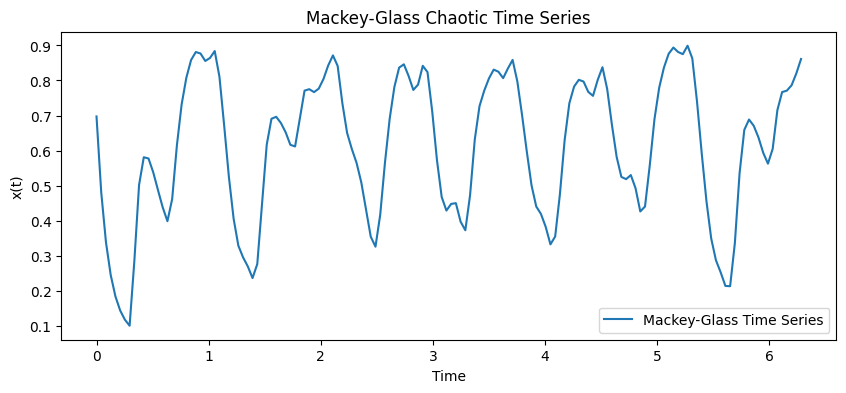

In [9]:
##### Plot the Mackey-Glass time series
plt.figure(figsize=(10, 4))
plt.plot(X, y, label='Mackey-Glass Time Series')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.title('Mackey-Glass Chaotic Time Series')
plt.legend()
plt.show()

### Prepare trainig and testing data partitions
*Note that QAE X and y will be the same (unless noise is injected into X).*<br>
*Also note that initially separate noisy partitions have been generated for visualisation only.*<br>
*In training, different noise is created at each training iteration.*<br>
*This is necessary to prevent QAE to learn the noisy signal itself.*

In [10]:
##### Data settings

### Training / testing data split
split = 2/3

### Window settings
wind_size = 5
wind_step = 2
horizon = 1
noise = 0.2

### Random seed(s)
seed = 2024

In [11]:
##### Create time series tensor data with optional noise 
#     Note that windows overlap by wind_step

def create_sw_tens(X, y, noise=0.0, wind_size=5, wind_step=2, range_low=0.2, range_high=0.8, seed=0):
    y_noisy = ts_add_noise(y, noise=noise, noise_type='normal', clip=False,
        range_low=range_low, range_high=range_high, seed=seed)
    y_ts = ts_wind_make(y_noisy, wind_size, wind_step)
    X_ts = ts_wind_make(X, wind_size, wind_step)
    X_train_ts, y_train_ts, X_test_ts, y_test_ts = ts_wind_split(X_ts, y_ts, split)

    X_train_tens = torch.tensor(X_train_ts, requires_grad=False)
    y_train_tens = torch.tensor(y_train_ts, requires_grad=False)
    X_test_tens = torch.tensor(X_test_ts, requires_grad=False)
    y_test_tens = torch.tensor(y_test_ts, requires_grad=False)
    return X_train_tens, y_train_tens, X_test_tens, y_test_tens

In [12]:
##### Preparation of sliding windows and their partitions

### Create windows and split into training and test partitions
X_train_coords, y_train_coords, X_test_coords, y_test_coords = \
        create_sw_tens(X, X, noise=0.0, wind_size=wind_size, wind_step=wind_step, range_low=y_low, range_high=y_high, seed=seed)
X_train_tens, y_train_tens, X_test_tens, y_test_tens = \
    create_sw_tens(y, y, noise=0.0, wind_size=wind_size, wind_step=wind_step, range_low=y_low, range_high=y_high, seed=seed)
_, X_train_noisy_tens, _, X_test_noisy_tens = \
    create_sw_tens(y, y, noise=noise, wind_size=wind_size, wind_step=wind_step, range_low=y_low, range_high=y_high, seed=seed)

### Find partition sizes
n_train = len(X_train_tens)
n_test = len(X_test_tens)

### Print a sample of data
if debug_level > 0:
    print('\nSample of training partition:\n\nWindow coordinates:')
    pprint(X_train_coords[0:3])
    print('\nWindow values:')
    pprint(X_train_tens[0:3]); 
    print('\nSample of test partition:\n\nWindow coordinates:')
    pprint(X_test_coords[0:3])
    print('\nWindow values:')
    pprint(X_test_tens[0:3]); print()

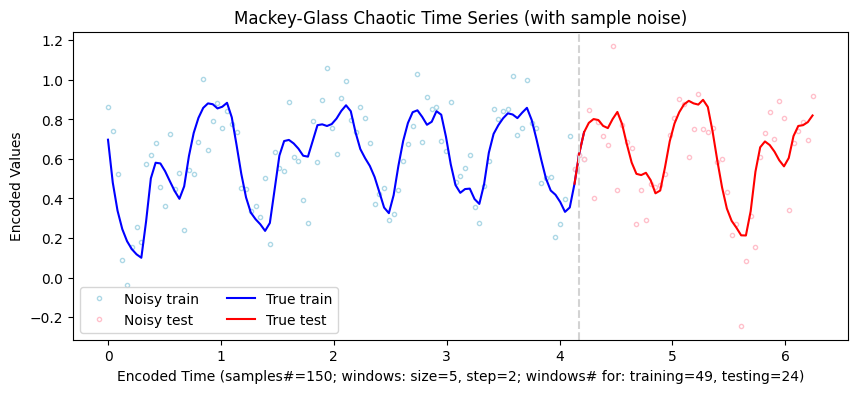

In [13]:
##### Plot flattened window partitions

### Flatten windows by averaging overlapping data
X_train_flat_ts = ts_wind_flatten_avg(X_train_tens, wind_step)
X_test_flat_ts = ts_wind_flatten_avg(X_test_tens, wind_step)
X_train_noisy_flat_ts = ts_wind_flatten_avg(X_train_noisy_tens, wind_step)
X_test_noisy_flat_ts = ts_wind_flatten_avg(X_test_noisy_tens, wind_step)
X_train_flat_coords = ts_wind_flatten_avg(X_train_coords, wind_step)
X_test_flat_coords = ts_wind_flatten_avg(X_test_coords, wind_step)

# Plot partitions
plt.figure(figsize=(10, 4))
plt.plot(X_train_flat_coords, X_train_noisy_flat_ts, label="Noisy train", color="lightblue", linestyle='', mfc='white', marker='.')
plt.plot(X_test_flat_coords, X_test_noisy_flat_ts, label="Noisy test", color="pink", linestyle='', mfc='white', marker='.')
plt.plot(X_train_flat_coords, X_train_flat_ts, label="True train", color="blue")
plt.plot(X_test_flat_coords, X_test_flat_ts, label="True test", color="red")
plt.axvline(x=(X_train_flat_coords[-1]+X_test_flat_coords[0])/2, color="lightgray", linestyle='--')
plt.xlabel(f'Encoded Time (samples#={n_samples}; windows: size={wind_size}, step={wind_step}; windows# for: training={n_train}, testing={n_test})')
plt.ylabel('Encoded Values')
plt.title('Mackey-Glass Chaotic Time Series (with sample noise)')
plt.legend(loc='best', ncol=2)
plt.show()

## <font color="blue">Model development</font>

### QAE hyper-parameters

In [14]:
##### QAE hyper-parameters

### Model params
rot = 'Rxyz' # Ry / Rxyz
n_layers = 4
n_latent = 3
n_extra = 2
n_epochs = 200 # 500 # 1000 # 2000
log_interv = 1
weight_scaler = 0.1

### Derived params
n_trash = wind_size - n_latent
n_data = n_latent + n_trash
n_wires = n_latent + 2*n_trash + 2*n_extra

### Other (CASE_NAME) invariant params
diff_method = 'adjoint' # 'best'
interface= 'torch'      # None, 'torch','autograd'
level='gradient'        # 'device', 'user'
shots = None            # We use a state vector simulator

### Simulator device

In [15]:
##### Quantum simulator
sim = 'lightning.qubit' # default.qubit lightning.qubit lightning.gpu

## Define, train and test a model
*Note that the trainnig model will be used further, however, the testting model is used only as a reference for its structural properties. The actual testing models will be generated dynamically.*

### Model creation

In [16]:
##### Creation of a model and its shape function

### Estimates the shape of the "full_qae"
#   n_latent: number of latent qubits
#   n_trash: number of trash qubits
#   n_layers: number of layers (repeats)
#   returns: shape
def full_qae_shape(n_latent, n_trash, n_extra=0, n_layers=1, rot='Ry'):
    n_wires = n_latent + n_trash + n_extra
    if rot == 'Ry':
        shape = qml.BasicEntanglerLayers.shape(n_layers=n_layers*2, n_wires=n_wires)
    elif  rot == 'Rxyz':
        shape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers*2, n_wires=n_wires)
    return shape

### Full-QAE Circuit: Input + Encoder + Swap for trash reset + Decoder + Output
#   wires: list/array of wires to create a full QAE
#   n_latent: number of latent qubits
#   n_trash: number of trash qubits
#   n_extra: number of additional qubits to increase circuit breadth
#   n_layers: number of layers (repeats)
#   rot: rotation type, 'Ry' or 'Rxyz'
#   add_outseq: if True, the inverse of the input sequence will be added on output
#   invert_dec: If True the decoder ansatz will be inverted
#   returns: QAE building function which takes arguments
#     inputs: list/array of input values to be angle encoded
#     weights: list/array of weights shaped to be used in ansatz blocks

def full_qae(wires, n_latent, n_trash, n_extra, n_layers=1, rot='Ry', add_outseq=True, invert_dec=True):

    latent_wires = wires[0:n_latent]
    trash_wires = wires[n_latent:n_latent+n_trash]
    extra_wires = wires[n_latent+n_trash:n_latent+n_trash+n_extra]
    reinit_wires = trash_wires + extra_wires
    zero_wires = wires[n_latent+n_trash+n_extra:n_latent+2*n_trash+2*n_extra]
    data_wires = latent_wires + trash_wires
    anz_wires = latent_wires + trash_wires + extra_wires

    ### Encodes a sequence on in put (similar to AngleEncoding)
    def _sequence_encoder(wires, inputs):
        qml.AngleEmbedding(features=inputs, wires=wires, rotation='Y')
    
    ### Entangler shape
    def _entangler_shape(n_layers, n_wires, rot='Ry'):
        if rot == 'Ry':
            return qml.BasicEntanglerLayers.shape(n_layers=n_layers, n_wires=n_wires)
        elif rot == 'Rxyz':
            return qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_wires)
        else:
            return ()

    ### Entangler
    def _entangler(wires, weights, rot='Ry'):
        if rot == 'Ry':
            qml.BasicEntanglerLayers(weights, wires=anz_wires, rotation=qml.RY)
        elif rot == 'Rxyz':
            qml.StronglyEntanglingLayers(weights, wires=anz_wires)

    ### Full QAE encoder
    def _full_qae(weights, inputs):
        
        nonlocal wires, n_latent, n_trash, n_extra, n_layers, rot
        nonlocal latent_wires, trash_wires, extra_wires, data_wires, anz_wires
        nonlocal reinit_wires, zero_wires, add_outseq, invert_dec
                
        n_anz_wires = n_latent + n_trash + n_extra 
        n_data = n_latent + n_trash
    
        # Add input encoder
        _sequence_encoder(data_wires, inputs)
        qml.Barrier(wires)

        # In case the weights are passed in as a vector without any shape
        weights_shape = full_qae_shape(n_latent, n_trash, n_extra, n_layers, rot)
        weights = weights.reshape(weights_shape)
    
        # Find encoder/decoder shapes
        #    This function assumes symmetric QAE so they are identical
        enc_weights_shape = _entangler_shape(n_layers, n_anz_wires, rot=rot)
        dec_weights_shape = enc_weights_shape
     
        # Split and shape weights for encoder and decoder ansatze
        enc_weights = weights[:n_layers].reshape(enc_weights_shape)
        dec_weights = weights[n_layers:].reshape(dec_weights_shape)

        # Add encoder ansatz
        _entangler(anz_wires, enc_weights, rot=rot)        
      
        # Add initialisation of trash and extra space
        qml.Barrier(wires)
        for fw, tw in zip(reinit_wires, zero_wires):
            qml.SWAP(wires=[fw, tw])
        qml.Barrier(wires)
    
        # Add decoder ansatz
        if invert_dec:
            qml.adjoint(_entangler)(anz_wires, dec_weights, rot=rot)
        else:
            _entangler(anz_wires, enc_weights, rot=rot)
        qml.Barrier(wires)
    
        # Add output sequence if needed
        if add_outseq:
            qml.adjoint(_sequence_encoder)(data_wires, inputs)
            
        return [qml.expval(qml.PauliZ(wires=w)) for w in data_wires]

    return _full_qae

In [17]:
if debug_level > 0:
    test_n_latent = 3; test_n_trash = 2; test_n_extra = 1; test_n_layers=2
    test_n_inputs = test_n_latent + test_n_trash
    test_n_wires = test_n_latent + 2*test_n_trash + 2*test_n_extra
    test_wires = list(range(test_n_wires))
    test_rot = 'Ry'
    
    test_shape = full_qae_shape(test_n_latent, test_n_trash, test_n_extra, n_layers=test_n_layers, rot=test_rot)
    test_n_weights = np.prod(test_shape)
    print(f'Full-QAE shape: {test_shape}, weights: {int(test_n_weights)}\n')
    
    test_data = torch.linspace(100, 200, test_n_inputs, requires_grad=False)
    test_weights = torch.rand(test_shape, requires_grad=True)
    
    print(f'Data ({test_data.shape}): \n{test_data}\n')
    print(f'Weights ({test_weights.shape}): \n{test_weights}\n')

In [18]:
if debug_level > 0:
    ### Testing full-QAE for training
    
    # Define a static full-QAE
    test_qae = full_qae(test_wires, test_n_latent, test_n_trash, test_n_extra, n_layers=test_n_layers, rot=test_rot, add_outseq=False, invert_dec=True)
    
    # Create and draw a full-QAE, add wires for SWAP space (only latent area goes through)
    test_dev = qml.device(sim, wires=range(test_n_wires+test_n_trash+test_n_extra), shots=shots)
    test_qae_qc = qml.QNode(test_qae, test_dev, interface=interface, diff_method=diff_method)
    draw_circuit(test_qae_qc, scale=0.4, title='Full-QAE with SWAP Trash Reset', level='device') \
        (test_weights, test_data) # expansion_strategy='device'/'gradient'

    # Apply the model to sample data
    results = test_qae_qc(test_weights, test_data) #[test_data, test_data])
    print(f'test_qae_qc(test_weights, test_data):\n{torch.stack(results)}\n')

Full-QAE shape: (8, 7, 3), weights: 168

Created QAE: wires#=11, latent#=3, trash#=2, extra#=2, zero#=4 (SWAP), layers#=4, rot="Rxyz"


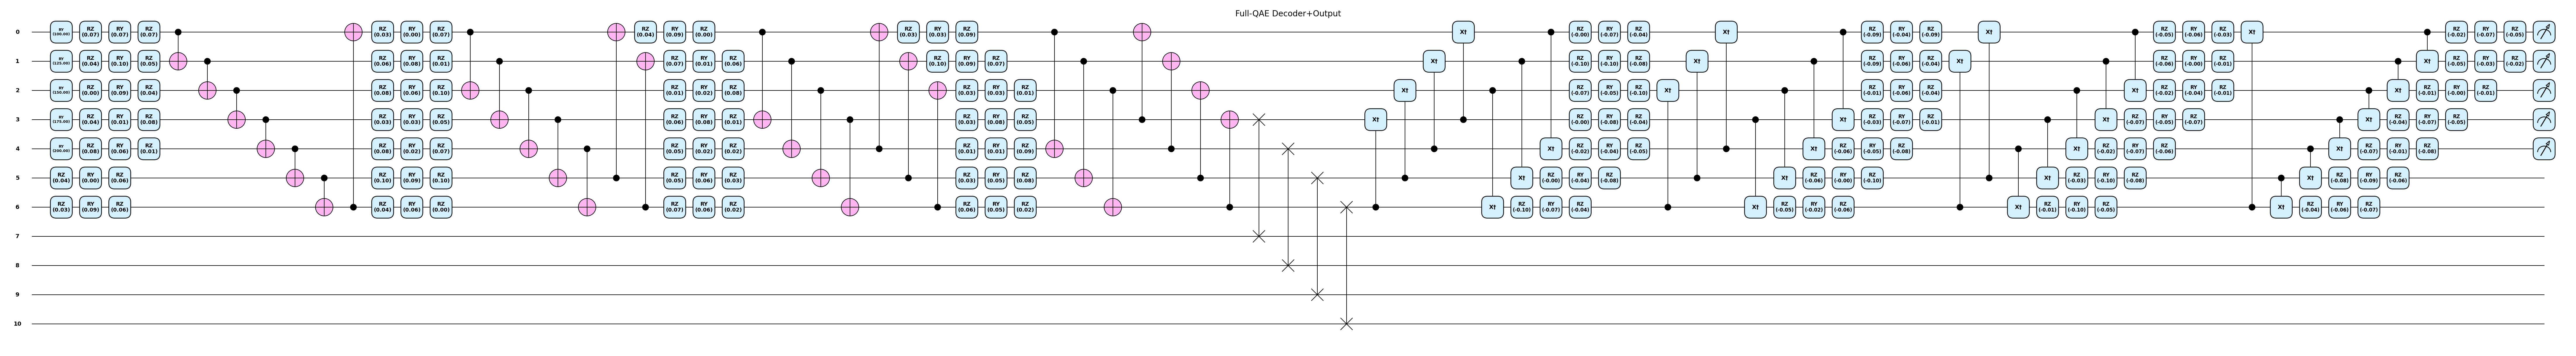

In [19]:
##### Create a model

wires = list(range(n_wires))

### Check the QAE shape
shape = full_qae_shape(n_latent, n_trash, n_extra, n_layers=n_layers, rot=rot)
n_weights = np.prod(shape)
print(f'Full-QAE shape: {shape}, weights: {int(n_weights)}\n')

### Select the random initial parameters to match the ansatz shape
sample_params = torch.rand(shape, requires_grad=True)*weight_scaler
sample_data = torch.linspace(100, 200, n_data, requires_grad=False)

qae = full_qae(wires, n_latent, n_trash, n_extra, n_layers=n_layers, rot=rot, add_outseq=False, invert_dec=True)
print(f'Created QAE: wires#={n_wires}, latent#={n_latent}, trash#={n_trash}, extra#={n_extra}, '+\
      f'zero#={n_trash+n_extra} (SWAP), layers#={n_layers}, rot="{rot}"')

# Create and draw a full-QAE
reserve_wires = n_trash+n_extra
dev = qml.device(sim, wires=n_wires+reserve_wires, shots=shots, seed=seed)
qae_model = qml.QNode(qae, dev, interface=interface, diff_method=diff_method)
draw_circuit(qae_model, scale=1, title='Full-QAE Decoder+Output', level='device') \
    (sample_params, sample_data) # expansion_strategy='device'/'gradient'

### Train the model

In [20]:
##### Training loop

def train_with_noise(model, X, y, cost_fun, optimizer, n_epochs,
                     log_interv=100, prompt_fract=0.1, start_time=0, level=2, seed=0,
                     wind_size=8, wind_step=4, noise=0, weight_scaler=0.1, scale_low=0, scale_high=2*np.pi):

    def closure():
        nonlocal X_noisy_tens, y_pure_tens, model, optimizer, cost_fun
        if torch.is_grad_enabled():
            optimizer.zero_grad()
        output = model(X_noisy_tens)
        cost = cost_fun(output, y_pure_tens)
        if cost.requires_grad:
            cost.backward()
        return cost

    ### For reproducibility
    #   Set a default random seed
    if seed == 0: seed = int(time.time()*1000) % 10000
    np.random.seed(seed)
    
    ### Prepare training
    hist_cost = []
    hist_params = []
    hist_noise = []
    
    ### Prepare tensors of pure training windows to be used as y output
    #   We ignore the test partition in training
    _, y_pure_tens, _, _ = create_sw_tens(X, y, noise=0, 
        wind_size=wind_size, wind_step=wind_step, range_low=scale_low, range_high=scale_high)
    
    ### Set the clock
    if start_time == 0: start_time = time.time() 
        
    ### Training loop
    for iter in range(n_epochs):
    
        # Add noise to pure windows to be used as X input
        #   We ignore the test partition in training
        _, X_noisy_tens, _, _ = create_sw_tens(X, y, noise=noise, seed=seed+iter,
            wind_size=wind_size, wind_step=wind_step, range_low=scale_low, range_high=scale_high)
        hist_noise.append(X_noisy_tens)

        # Reset optimiser gradients
        optimizer.zero_grad()

        # Perform a forward step, note that returned output is transposed 
        params = optimizer.param_groups[0]['params'][0].clone()
        output = torch.stack(model(params, X_noisy_tens)).t()
        cost = cost_fun(output, y_pure_tens)

        elapsed_time = time.time()-start_time
        if iter % log_interv == 0:
            hist_cost.append(cost.item())
            hist_params.append(params)
        if (prompt_fract == 0) or (iter % int(prompt_fract*n_epochs) == 0):
            print(f'Iter: {iter:03d} ({int(elapsed_time):04d} sec) cost={np.round(cost.item(), 6)}')
    
        # Perform a backward step
        cost.backward()
        optimizer.step()

    ### Print the training summary
    min_cost = np.min(hist_cost)
    min_iter = np.argmin(hist_cost)
    opt_params = hist_params[min_iter]
    
    ### Print the training summary
    print(f'\nTraining completed: epochs={n_epochs}, min cost={np.round(min_cost, 6)} @ {min_iter}, time={int(elapsed_time):03d} secs\n')

    return hist_cost, hist_params, init_weights, hist_noise, (min_iter, min_cost, elapsed_time)

In [21]:
##### Prepare for training

### For reproducibility
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Initialise parameters
init_weights = torch.tensor(np.random.rand(n_weights)*np.pi*weight_scaler, requires_grad=True)

### Select a PyTorch optimiser
opt = torch.optim.Adam([init_weights], lr=0.01)

### Select loss function
mse_loss = torch.nn.MSELoss()

In [22]:
##### Train the model

hist_cost, hist_params, init_weights, hist_noise, stats = \
    train_with_noise(qae_model, X, y, mse_loss, opt, n_epochs,
        wind_size=wind_size, wind_step=wind_step, noise=noise, scale_low=y_low, scale_high=y_high,
        log_interv=log_interv, prompt_fract=0.1, start_time=0, level=2, seed=seed)

Iter: 000 (0001 sec) cost=0.256125
Iter: 020 (0030 sec) cost=0.099784
Iter: 040 (0055 sec) cost=0.052188
Iter: 060 (0081 sec) cost=0.039935
Iter: 080 (0110 sec) cost=0.030447
Iter: 100 (0138 sec) cost=0.022552
Iter: 120 (0168 sec) cost=0.017496
Iter: 140 (0198 sec) cost=0.0166
Iter: 160 (0227 sec) cost=0.014584
Iter: 180 (0254 sec) cost=0.015828

Training completed: epochs=200, min cost=0.012416 @ 183, time=282 secs



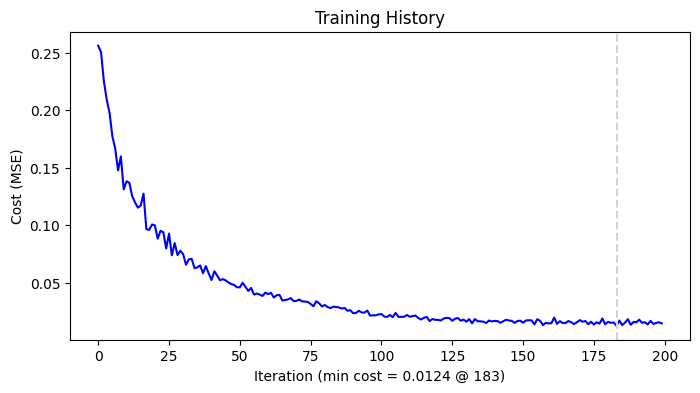

In [23]:
### Plot training cost

# Find the minimum cost
min_cost = np.min(hist_cost)
min_idx = np.argmin(hist_cost)

# Plot the chart
plt.figure(figsize=(8, 4))
plt.plot(hist_cost, label="Cost", color="blue")
plt.axvline(x=min_idx, color="lightgray", linestyle='dashed')
plt.xlabel(f'Iteration (min cost = {min_cost:0.4f} @ {min_idx})')
plt.ylabel('Cost (MSE)')
plt.title('Training History')
plt.show()

## Test the model

### Create an "optimum" model
*Note we have the parameters for all models developed in training.*<br>
*However, we have never scored these models, although, we really should have!*<br>
*Instead we selected the "best" model based on the training scores (actually - costs).*

In [24]:
##### Apply optimum model to data partitions and flatten them

### Identify optimum training parameters 
opt_params = hist_params[stats[0]]

### Reconstruct pure and noisy training TSs
pred_from_pure_train_tens = torch.stack(qae_model(opt_params, X_train_tens)).t().detach().numpy()
pred_from_pure_test_tens = torch.stack(qae_model(opt_params, X_test_tens)).t().detach().numpy()
pred_from_noisy_train_tens = torch.stack(qae_model(opt_params, X_train_noisy_tens)).t().detach().numpy()
pred_from_noisy_test_tens = torch.stack(qae_model(opt_params, X_test_noisy_tens)).t().detach().numpy()

### Flatten recovered TSs
pred_from_pure_train_flat = ts_wind_flatten_avg(pred_from_pure_train_tens, wind_step)
pred_from_pure_test_flat = ts_wind_flatten_avg(pred_from_pure_test_tens, wind_step)
pred_from_noisy_train_flat = ts_wind_flatten_avg(pred_from_noisy_train_tens, wind_step)
pred_from_noisy_test_flat = ts_wind_flatten_avg(pred_from_noisy_test_tens, wind_step)

### Flatten all collected Gaussian noise used in training
#   It is used only as an illustration for plotting
flat_noisy_ts = []
for noisy_ts in hist_noise:
    noisy_y_points = ts_wind_flatten_avg(noisy_ts, wind_step)
    flat_noisy_ts.append(noisy_y_points)
flat_noisy_ts = np.stack(flat_noisy_ts).numpy()

In [25]:
##### Calculate metrics to show in charts
#     Note that all pure X = pure y, noise was injected into X only

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mse_train_pure_vs_noisy = mean_squared_error(X_train_flat_ts, X_train_noisy_flat_ts)
mse_train_pure_vs_rec_from_noisy = mean_squared_error(X_train_flat_ts, pred_from_noisy_train_flat)
mse_test_pure_vs_noisy = mean_squared_error(X_test_flat_ts, X_test_noisy_flat_ts)
mse_test_pure_vs_rec_from_noisy = mean_squared_error(X_test_flat_ts, pred_from_noisy_test_flat)

print(f'MSE train (pure vs noise) ~ (pure vs recovered) = {mse_train_pure_vs_noisy:0.4f} ~ {mse_train_pure_vs_rec_from_noisy:0.4f}')
print(f'MSE test  (pure vs noise) ~ (pure vs recovered) = {mse_test_pure_vs_noisy:0.4f} ~ {mse_test_pure_vs_rec_from_noisy:0.4f}')

MSE train (pure vs noise) ~ (pure vs recovered) = 0.0199 ~ 0.0124
MSE test  (pure vs noise) ~ (pure vs recovered) = 0.0285 ~ 0.0107


### Compare pure data vs noisy and recovered data

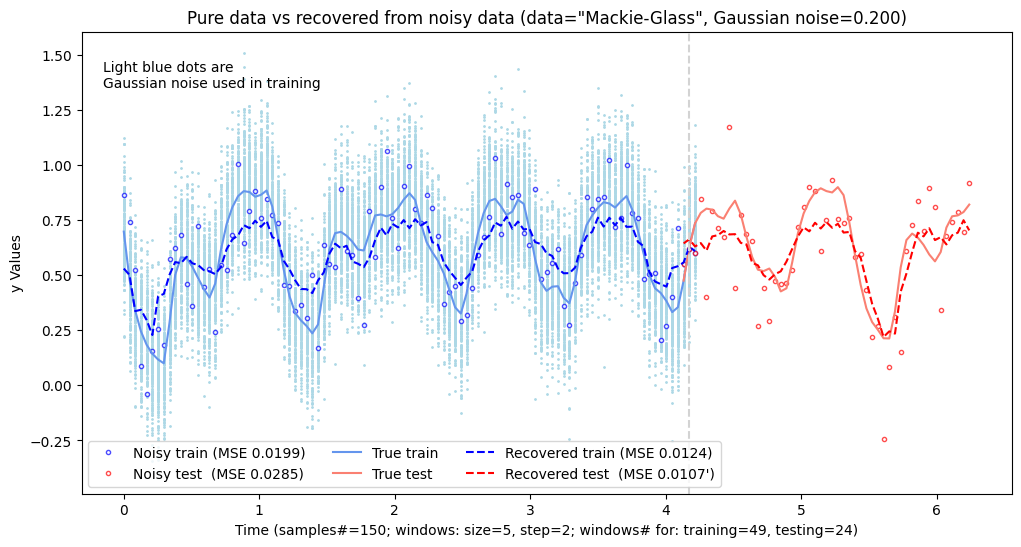

In [26]:
##### Plot the original and recovered data with added performance metrics

### Prepare X, y lists for plotting
X_list = [X_train_flat_coords, X_test_flat_coords, 
          X_train_flat_coords, X_test_flat_coords, 
          X_train_flat_coords, X_test_flat_coords]
y_list = [X_train_noisy_flat_ts, X_test_noisy_flat_ts,
          X_train_flat_ts, X_test_flat_ts, 
          pred_from_noisy_train_flat, pred_from_noisy_test_flat]

### Plot partitions
print()
plt.figure(figsize=(12, 6))
for noisy_ts in flat_noisy_ts:
    plt.plot(X_train_flat_coords, noisy_ts, color="lightblue", linestyle='', marker='.', markersize=2)
plt.plot(X_train_flat_coords, X_train_noisy_flat_ts, color="blue", alpha=0.7, linestyle='', mfc='white', marker='.', 
         label=f"Noisy train (MSE {mse_train_pure_vs_noisy:0.4f})")
plt.plot(X_test_flat_coords, X_test_noisy_flat_ts, color="red", alpha=0.7, linestyle='', mfc='white', marker='.', 
         label=f"Noisy test  (MSE {mse_test_pure_vs_noisy:0.4f})")
plt.plot(X_train_flat_coords, X_train_flat_ts, label="True train", color="cornflowerblue")
plt.plot(X_test_flat_coords, X_test_flat_ts, label="True test", color="salmon")
plt.plot(X_train_flat_coords, pred_from_noisy_train_flat, color="blue", linestyle='dashed', 
         label=f"Recovered train (MSE {mse_train_pure_vs_rec_from_noisy:0.4f})")
plt.plot(X_test_flat_coords, pred_from_noisy_test_flat, color="red", linestyle='dashed', 
         label=f"Recovered test  (MSE {mse_test_pure_vs_rec_from_noisy:0.4f}')")
plt.axvline(x=(X_train_flat_coords[-1]+X_test_flat_coords[0])/2, color="lightgray", linestyle='dashed')
plt.text(-0.15, 1.35, 'Light blue dots are\nGaussian noise used in training')
plt.xlabel(f'Time (samples#={n_samples}; windows: size={wind_size}, step={wind_step}; windows# for: training={n_train}, testing={n_test})')
plt.ylabel('y Values')
plt.title(f'Pure data vs recovered from noisy data (data="Mackie-Glass", Gaussian noise={noise:0.3f})')
plt.legend(loc='lower left', ncol=3)
plt.show()
print()

## Write your observations here

- Observation 1:
- Observation 2:
- Observation 3:
- Observation 4:
- Observation 5:
- Observation 6:
- Observation 7:


# Software in use (Linux)

In [27]:
import os
os.system('pip list | grep -e pennylane -e torch');

pennylane                 0.42.3
pennylane_lightning       0.42.0
torch                     2.8.0
torchaudio                2.8.0
torcheval                 0.0.7
torchmetrics              1.8.2
torchsummary              1.5.1
torchvision               0.23.0
